In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [4]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [5]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [90]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [8]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [9]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Other features

In [41]:
x_dict = {}
x_extra_dict = {}

In [42]:
x_dict['scalars'] = scalar_featurizer.scalar_features
x_extra_dict['scalars'] = x_features_extra

x_dict['geos'] = utils.geo_feature_arr_to_values(scalar_featurizer.geo_feature_arr)
x_extra_dict['geos'] = x_features_extra

x_dict['mrv'] = x_features_extra
x_extra_dict['mrv'] = None

catalog_feature_names = ['M200c', 'c200c', 'a_form']
sim_reader.get_structure_catalog_features(catalog_feature_names)
x_dict['catalog'] = sim_reader.x_catalog_features
x_extra_dict['catalog'] = None

## Gather properties

In [43]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [44]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [45]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = None
x_test_extra = x_features_extra[idx_test]

# Explore color

In [23]:
phot_file = f'{sim_reader.tng_path_hydro}/postprocessing/stellar_photometry/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_{sim_reader.snap_num_str}.hdf5'
f_phot = h5py.File(phot_file)
print(f_phot.keys())
phot = f_phot['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc']
print(phot.shape)
# columns: sdss_u, sdss_g, sdss_r, sdss_i, sdss_z, wfc_acs_f606w, des_y, jwst_f150w

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>
(4371211, 8, 12)


In [35]:
gband_all = phot[:,1,0]

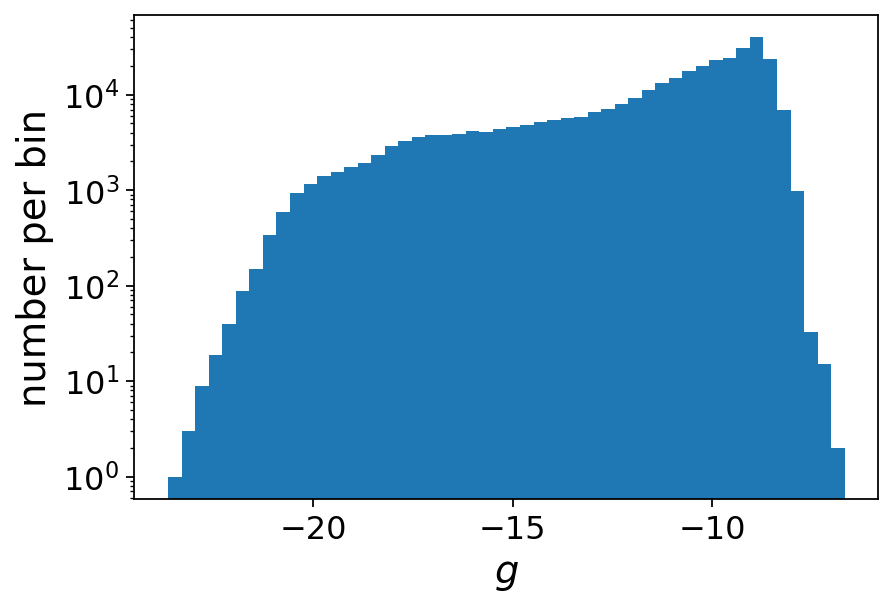

In [36]:
plt.hist(gband_all, bins=50)
plt.xlabel(r'$g$')
plt.ylabel('number per bin')
plt.yscale('log')

In [28]:
sim_reader.add_catalog_property_to_halos('gband')
gband = np.array([halo.catalog_properties['gband'] for halo in sim_reader.dark_halo_arr])

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


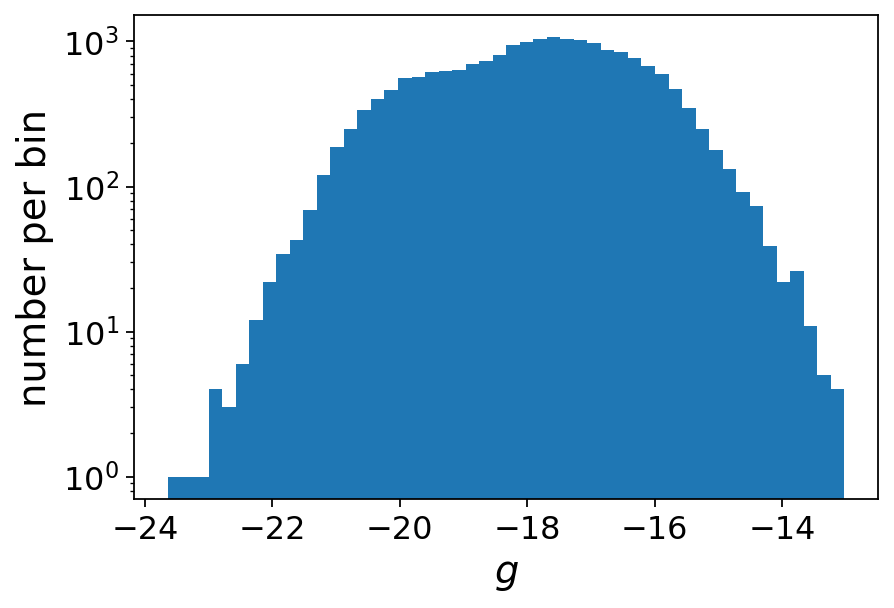

In [32]:
plt.hist(gband, bins=50)
plt.xlabel(r'$g$')
plt.ylabel('number per bin')
plt.yscale('log')

In [37]:
gminusi_all = phot[:,1,0] - phot[:,3,0]

In [38]:
sim_reader.add_catalog_property_to_halos('gband_minus_iband')
gminusi = np.array([halo.catalog_properties['gband_minus_iband'] for halo in sim_reader.dark_halo_arr])

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


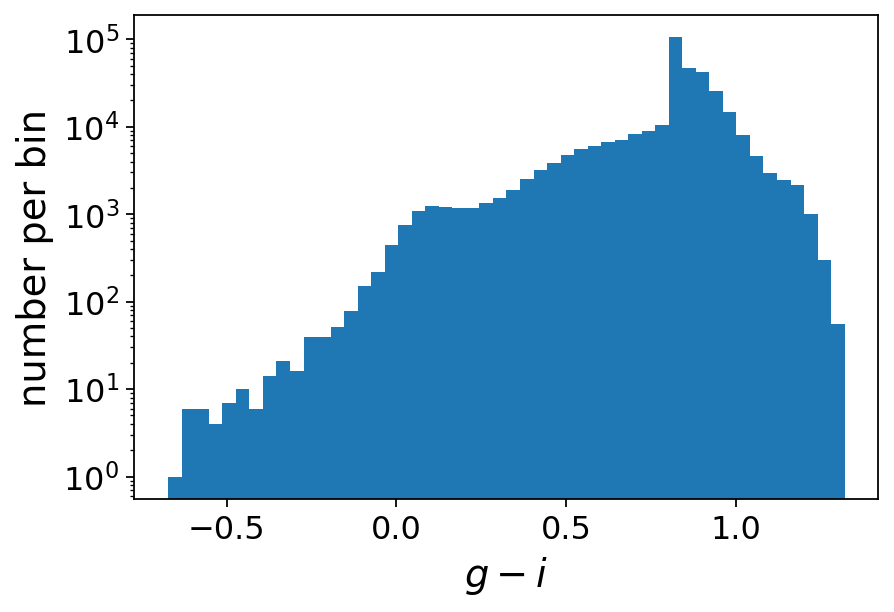

In [39]:
plt.hist(gminusi_all, bins=50)
plt.xlabel(r'$g - i$')
plt.ylabel('number per bin')
plt.yscale('log')

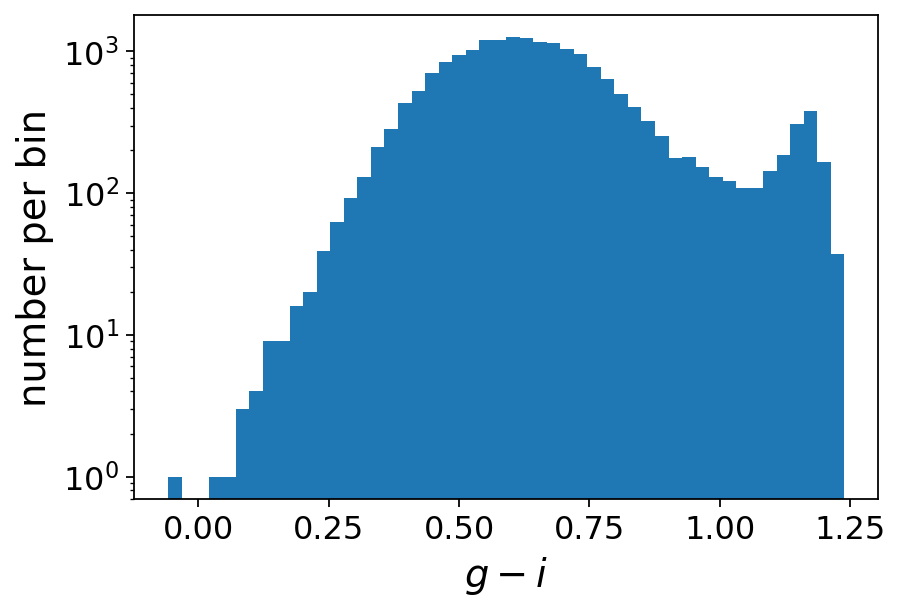

In [40]:
plt.hist(gminusi, bins=50)
plt.xlabel(r'$g - i$')
plt.ylabel('number per bin')
plt.yscale('log')

# Prediction

## G-band

In [46]:
y_label_name = 'gband'

In [51]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [52]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


In [53]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [54]:
import torch
model_checkpoint = torch.load(fn_model)

88 0.07614766818904571


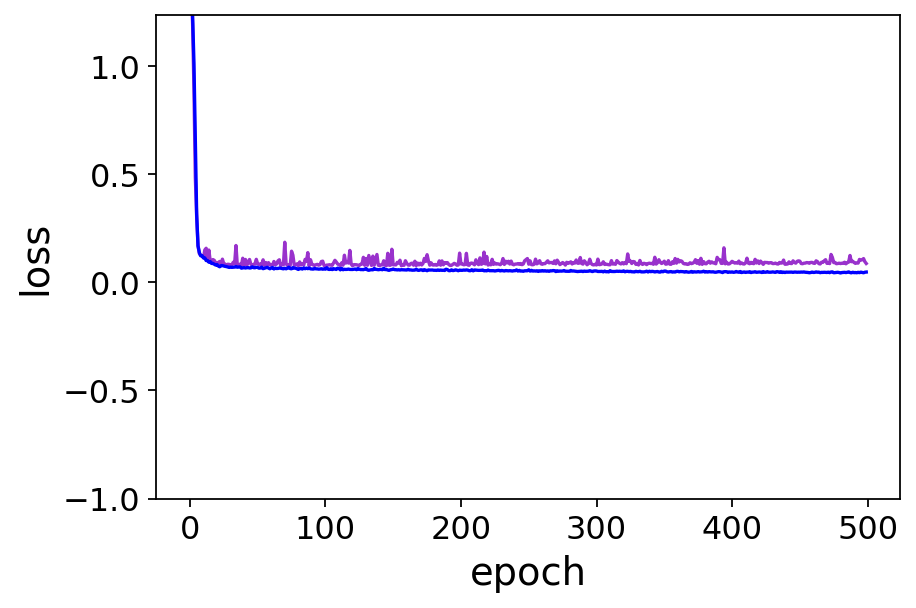

In [55]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [56]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


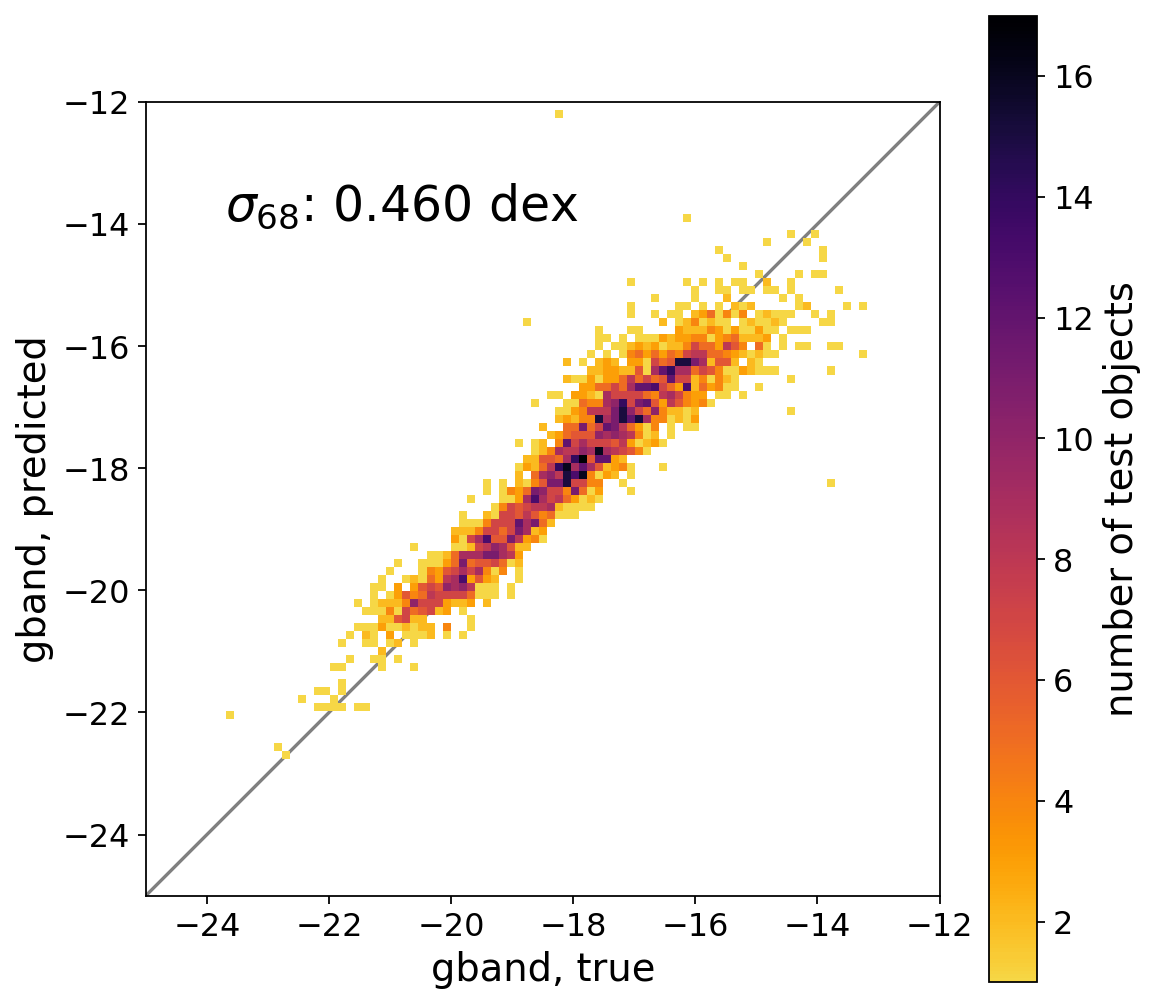

In [61]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(-25, -12),  y_lim=(-25, -12))

# g-i

In [62]:
y_label_name = 'gband_minus_iband'

In [66]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [67]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


In [68]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [69]:
import torch
model_checkpoint = torch.load(fn_model)

444 8.09735850376663


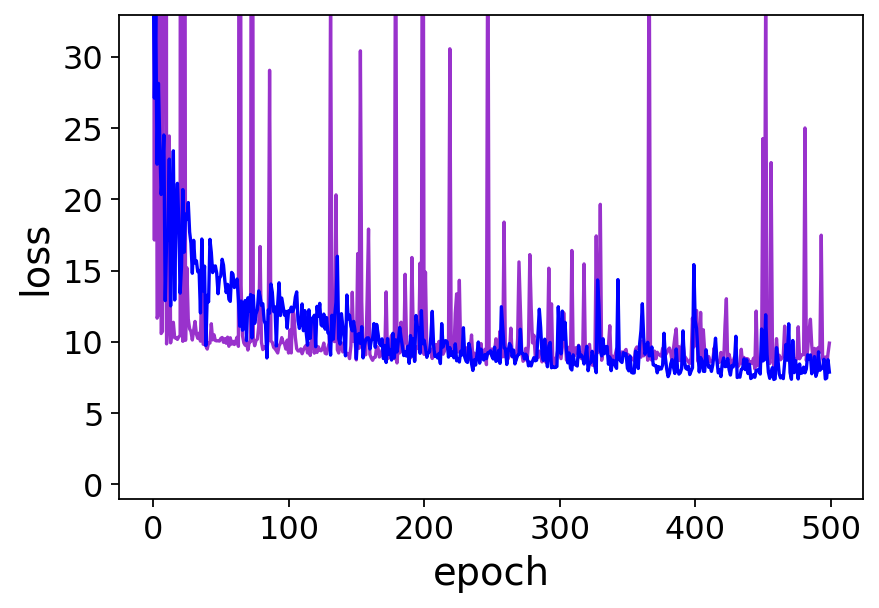

In [70]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [71]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


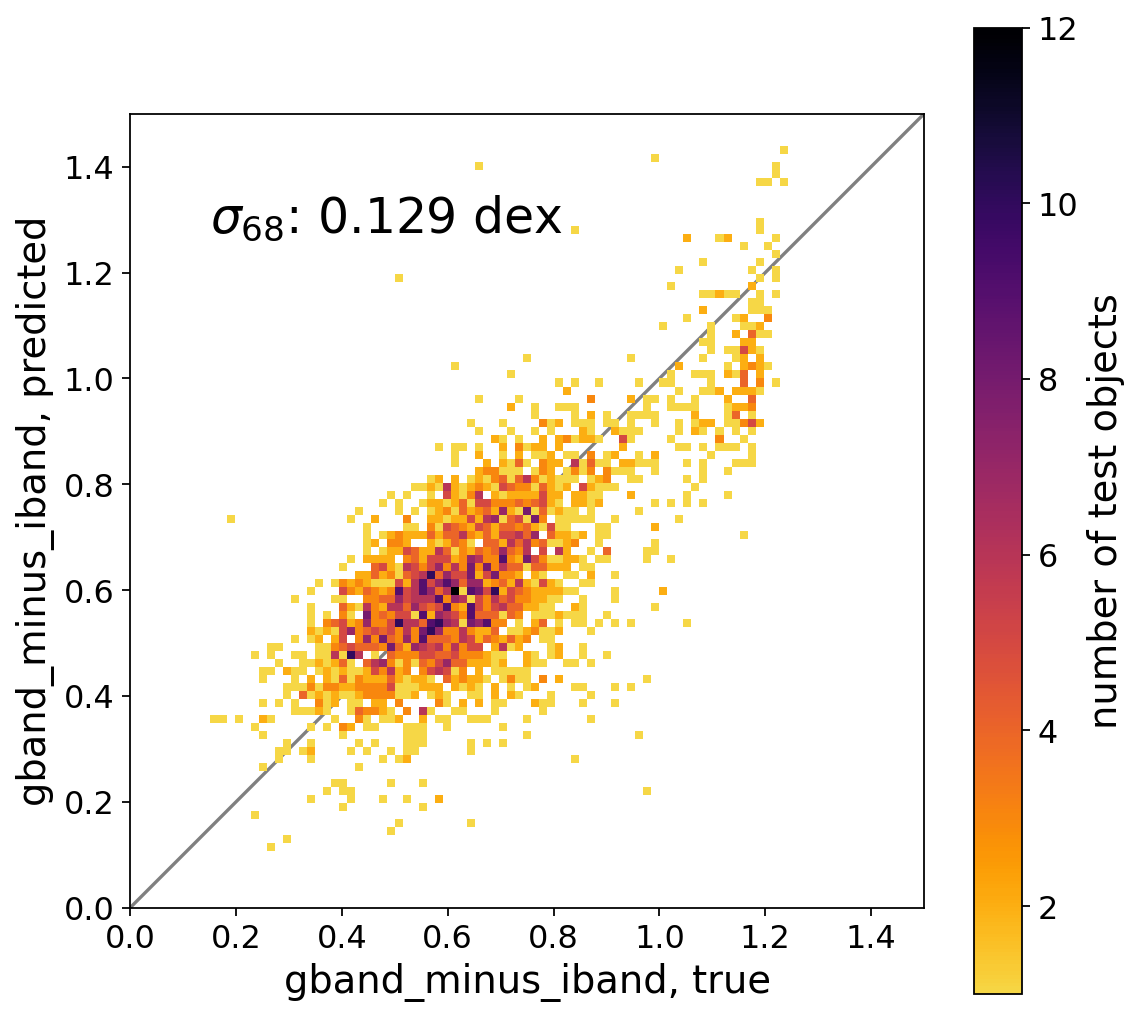

In [73]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(0, 1.5),  y_lim=(0, 1.5))

# Explore angular momentum

In [80]:
fn_stellar = f'{sim_reader.tng_path_hydro}/postprocessing/stellar_circs.hdf5'
f_stellar = h5py.File(fn_stellar)
stellar = f_stellar[f'Snapshot_{sim_reader.snap_num}']
print(stellar.keys())
print(stellar['SpecificAngMom'].shape)

<KeysViewHDF5 ['CircAbove07Frac', 'CircAbove07Frac_allstars', 'CircAbove07MinusBelowNeg07Frac', 'CircAbove07MinusBelowNeg07Frac_allstars', 'CircTwiceBelow0Frac', 'CircTwiceBelow0Frac_allstars', 'MassTensorEigenVals', 'ReducedMassTensorEigenVals', 'SpecificAngMom', 'SpecificAngMom_allstars', 'SubfindID']>
(32910,)


In [81]:
j_stellar = stellar['SpecificAngMom']

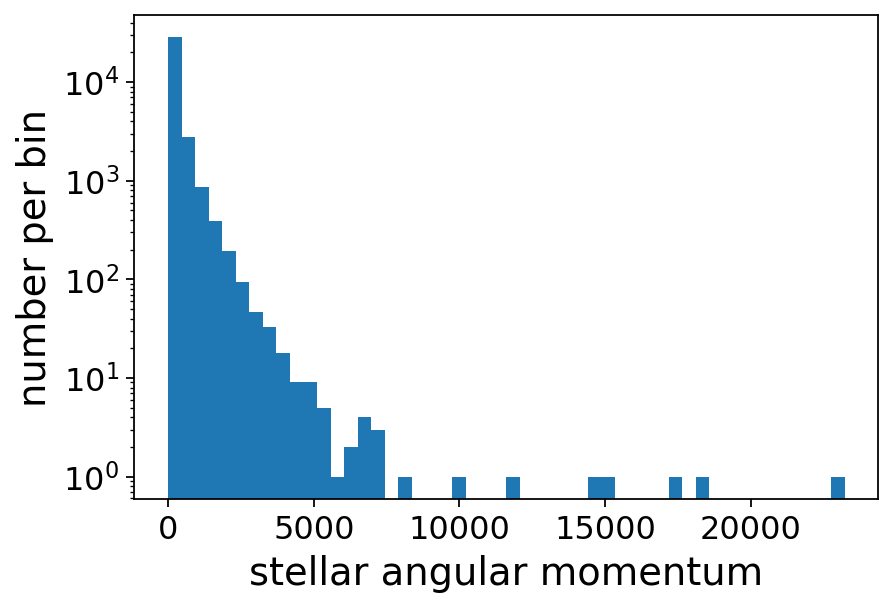

In [87]:
plt.hist(j_stellar, bins=50)
plt.xlabel('stellar angular momentum')
plt.ylabel('number per bin')
#plt.xscale('log')
plt.yscale('log')

# Black hole mass

In [91]:
sim_reader.add_catalog_property_to_halos('bhmass')
bhmass = np.array([halo.catalog_properties['bhmass'] for halo in sim_reader.dark_halo_arr])

In [105]:
print(np.min(bhmass), np.max(bhmass))

0.0 0.8383246


In [109]:
idx_nonzero = bhmass != 0.0
print(np.sum(idx_nonzero)/len(idx_nonzero))

0.9892221657346213


In [110]:
print(np.min(bhmass[idx_nonzero]))

8e-05


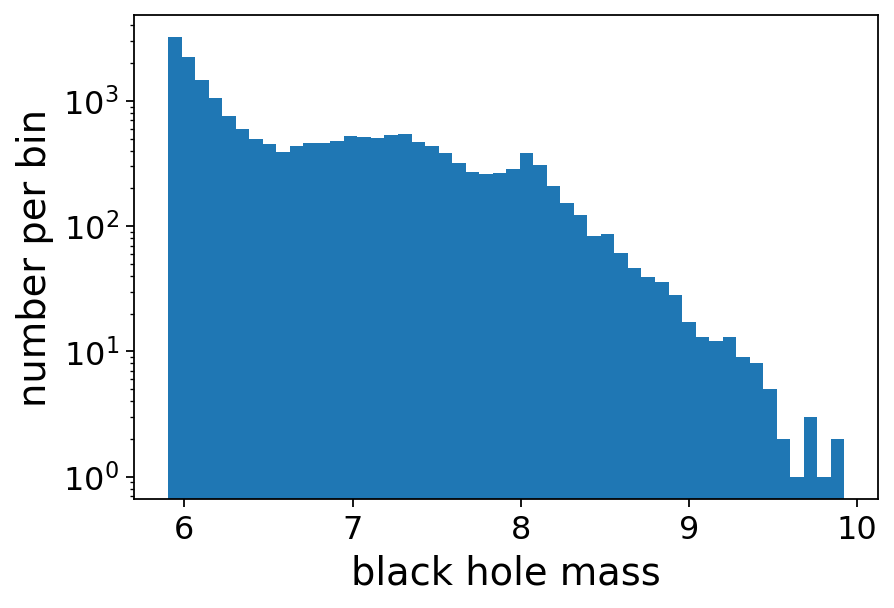

In [108]:
plt.hist(np.log10(bhmass[idx_nonzero])+log_mass_shift, bins=50)
plt.xlabel('black hole mass')
plt.ylabel('number per bin')
plt.yscale('log')

In [113]:
bhm = utils.get_y_vals('bhmass', sim_reader)

Text(0, 0.5, 'bhmass')

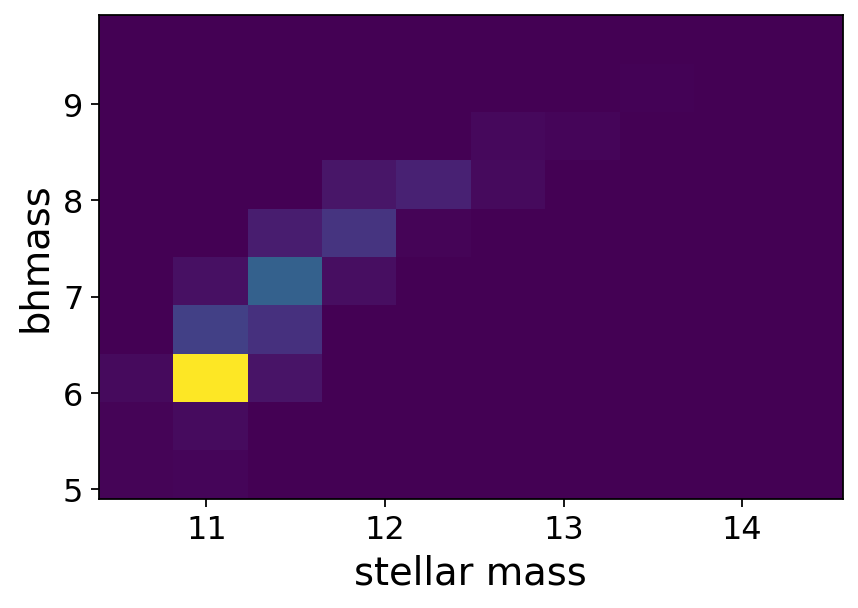

In [114]:

#plt.hist2d(np.log10(m_200m)+log_mass_shift, np.log10(bhmass[idx_nonzero])+log_mass_shift)
plt.hist2d(np.log10(m_200m)+log_mass_shift, bhm+log_mass_shift)


plt.xlabel('stellar mass')
plt.ylabel('bhmass')
#plt.yscale('log')

In [115]:
y_label_name = 'bhmass'

In [116]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [117]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [118]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

FileNotFoundError: [Errno 2] No such file or directory: '../models/models_TNG100-1/model_TNG100-1_bhmass_nn_scalars_epochs500_lr5e-05_hs128.pt'

In [119]:
import torch
model_checkpoint = torch.load(fn_model)

FileNotFoundError: [Errno 2] No such file or directory: '../models/models_TNG100-1/model_TNG100-1_bhmass_nn_scalars_epochs500_lr5e-05_hs128.pt'

In [120]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

AttributeError: 'NNFitter' object has no attribute 'loss_valid'

In [121]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

AttributeError: 'NNFitter' object has no attribute 'scaler'

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:332: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  # little h via https://www.tng-project.org/data/downloads/TNG100-1/


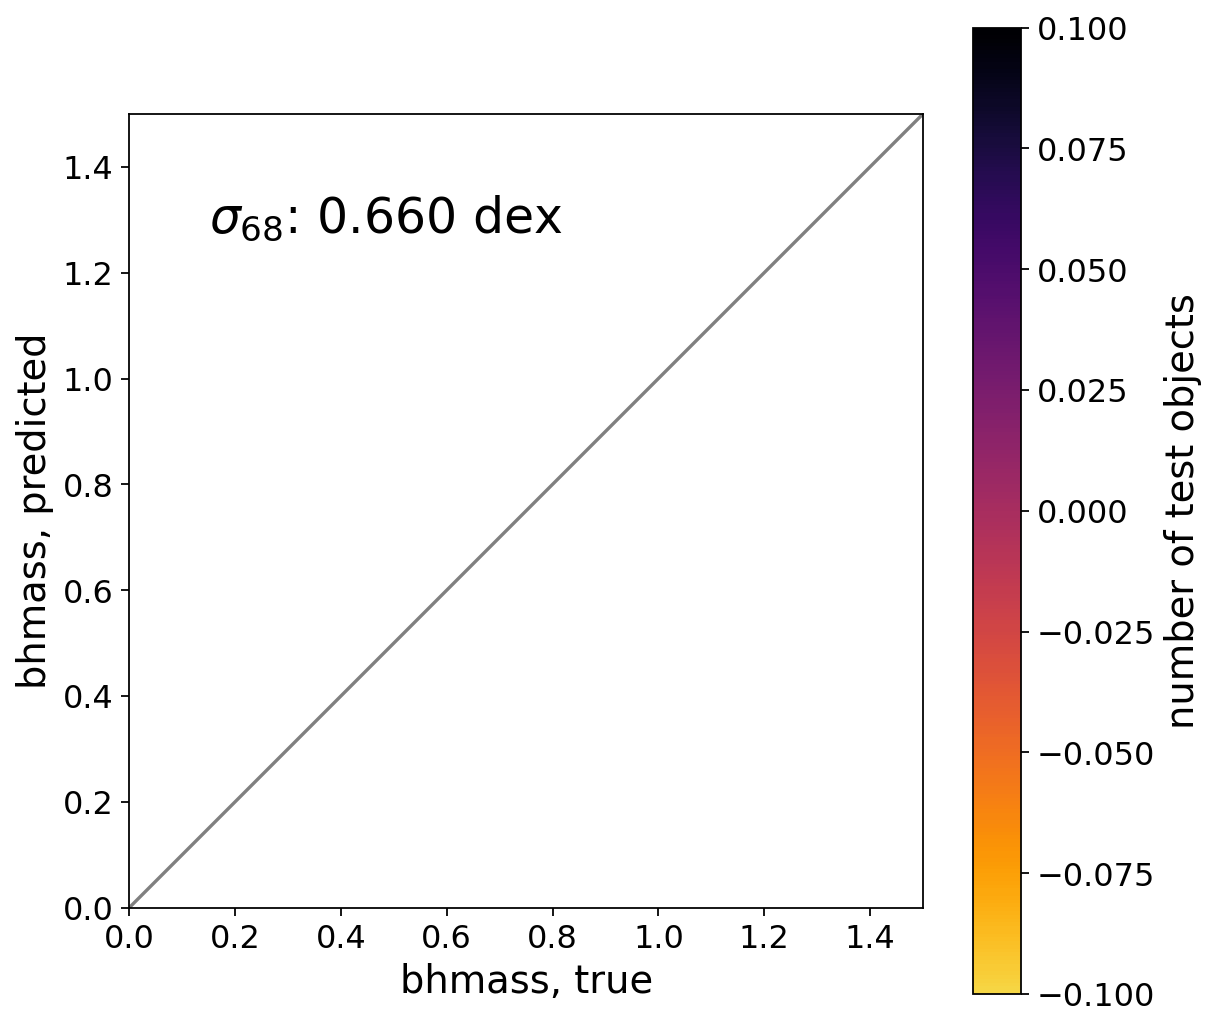

In [122]:
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(5.5,10.5),  y_lim=(5.5,10.5))